<a href="https://colab.research.google.com/github/DimosthenisDimoulias/datastories_for_emme/blob/main/stance-justification-thematic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving deliberation_comments_104.xlsx to deliberation_comments_104 (15).xlsx


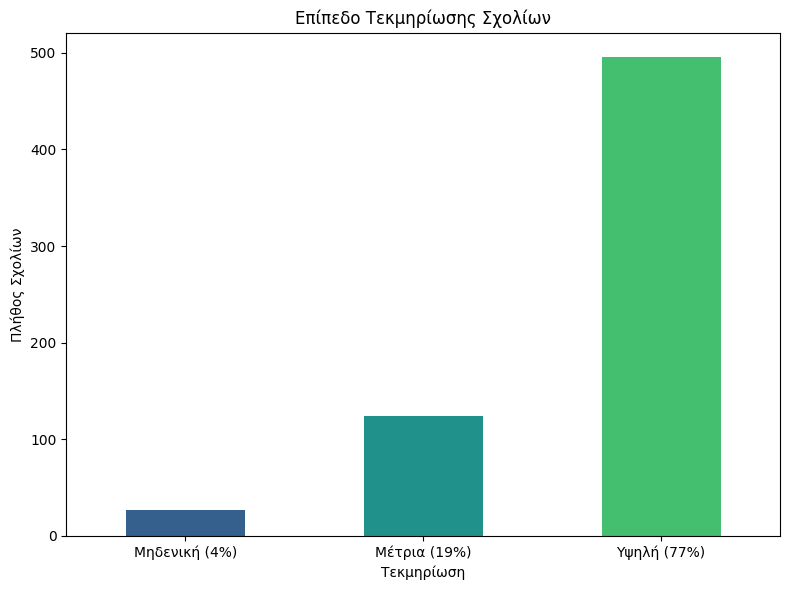

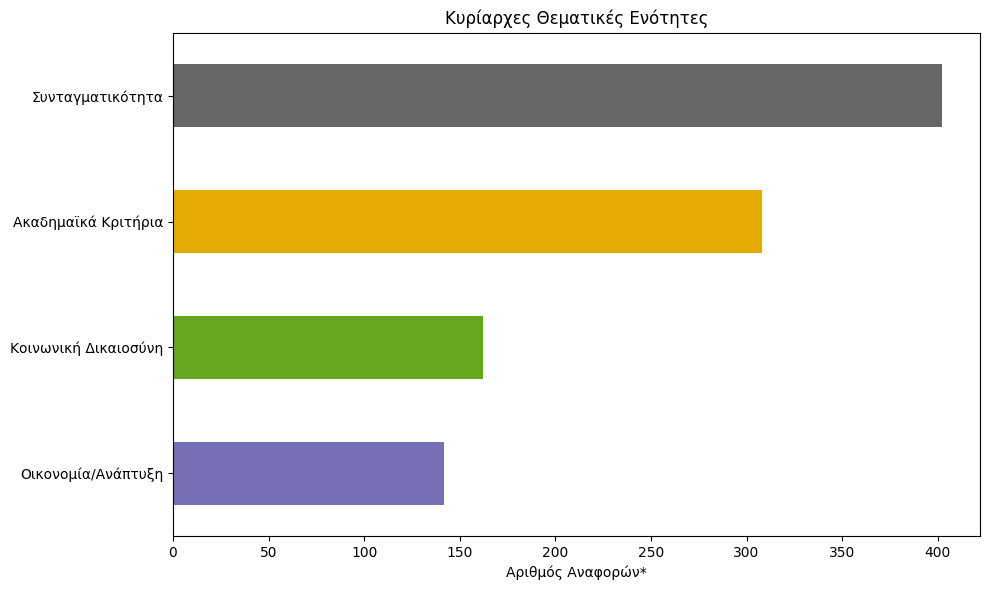


Substantiation Counts:
Substantiation
Μηδενική (4%)     27
Μέτρια (19%)     124
Υψηλή (77%)      496
Name: count, dtype: int64

Theme Counts:
Οικονομία/Ανάπτυξη      142
Κοινωνική Δικαιοσύνη    162
Ακαδημαϊκά Κριτήρια     308
Συνταγματικότητα        402
dtype: int64

Sample High Substantiation Comments:
[]

Sample Negative Comments:
['Αν και αντισυνταγματικό το σχέδιο νόμου, θα το περάσετε με τον ένα ή άλλο τρόπο.\n\nΟπότε πρόταση μου. Εξασφαλίστε το επίπεδο των εισελθοντων.\n\nΤο 0.8*ΕΒΕ (Ελάχιστη βάση εισαγωγής) σημαίνει ότι θα μπαίνει φοιτητής σε ιατρική με 8000μορια.\n\nΥποχρεωστε τα ιδιωτικά εκπαιδευτήρια να παίρνουν φοιτητές με βάση την μικρότερη βάση της αντίστοιχης σχολής του δημοσίου.\n\nΑν π.χ. η Ιατρική έχει βάση 18.000 στο πανεπιστήμιο Ιωαννίνων (τυχαίο παράδειγμα) και αυτή είναι η μικρότερη βάση μεταξύ όλων των Ιατρικών σχολών, τότε θα ορίζεται ΕΘΝΙΚΉ βάση στα ιδιωτικά εκπαιδευτήρια αυτή ή έστω κάποιο ποσοστό αυτής 0.9? 0.8 αλλά της Ιατρικής!\n\nΕξασφαλίστε ότι θα πηγαίνο

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
from google.colab import files

# Load the dataframe
uploaded = files.upload()

df = pd.read_excel(list(uploaded.keys())[0])

# Preprocessing
df['Σχόλιο'] = df['Σχόλιο'].astype(str)
df['Σχόλιο_lower'] = df['Σχόλιο'].str.lower()

# --- 1. Stance Analysis (Sentiment/Stance) ---
# Keywords
positive_keywords = ['συμφωνώ', 'θετικό', 'ορθό', 'μπράβο', 'επιτέλους', 'αναγκαίο', 'εκσυγχρονισμός', 'ευκαιρία', 'πρόοδος', 'σωστή κατεύθυνση']
negative_keywords = ['διαφωνώ', 'όχι', 'απαράδεκτο', 'απόσυρση', 'αντισυνταγματικό', 'καταστροφή', 'ντροπή', 'αίσχος', 'ιδιωτικοποίηση', 'παραβίαση', 'κατάργηση', 'εμπορευματοποίηση', 'όχι στα ιδιωτικά']

def classify_stance(text):
    text = text.lower()
    # Check for negative first as they are likely more emphatic in this context
    if any(k in text for k in negative_keywords):
        return 'Αρνητική'
    elif any(k in text for k in positive_keywords):
        return 'Θετική'
    else:
        # Heuristic: If it contains specific questions or technical terms without emotive words, maybe Neutral/Technical
        # For simplicity, if not explicitly positive or negative, we map to "Ουδέτερη/Τεχνική"
        # However, many "Withdraw it" comments might be short.
        return 'Ουδέτερη/Τεχνική'

df['Stance'] = df['Σχόλιο'].apply(classify_stance)

# --- 2. Level of Substantiation ---
# Heuristics based on length and vocabulary
def classify_substantiation(text):
    words = text.split()
    num_words = len(words)
    text_lower = text.lower()

    high_keywords = ['άρθρο 16', 'σύνταγμα', 'στε', 'νομολογία', 'ευρωπαϊκό δίκαιο', 'παρ.', 'ν.', 'συνεπώς', 'δεδομένου', 'τεκμηριώνει', 'αντίθεση', 'αιτιολογική έκθεση','εβε','μελέτη','συμβούλιο της επικρατείας','έρευνα','οδηγία','βάση εισαγωγής','ενωσιακό δίκαιο','συνταγμ','επιστημ']

    if num_words < 20:
        return 'Μηδενική (4%)'

    # If it has significant length AND technical/legal vocabulary -> High
    if num_words > 50 and any(k in text_lower for k in high_keywords):
        return 'Υψηλή (77%)'
    # Or just very long texts often imply effort/argumentation
    if num_words > 150:
        return 'Υψηλή (77%)'

    return 'Μέτρια (19%)'

df['Substantiation'] = df['Σχόλιο'].apply(classify_substantiation)

# --- 3. Thematic Framing ---
# Note: A comment can belong to multiple themes
themes = {
    'Συνταγματικότητα': ['σύνταγμα', 'άρθρο 16', 'αντισυνταγματικό','αντισυνταγματικ', 'νομιμότητα', 'παραβίαση', 'στε','ΣτΕ','Σύνταγμα','Ευρωπαϊκό Δίκαιο','ευρωπαϊκό δίκαιο'],
    'Ακαδημαϊκά Κριτήρια': ['εβε', 'βάση εισαγωγής', 'ποιότητα', 'αξιολόγηση', 'υποδομές', 'πτυχίο', 'εθχααε', 'εθααε', 'πιστοποίηση', 'επαγγελματικά δικαιώματα', 'αναγνώριση','ΕΒΕ','πτυχί','ακαδημαϊκ'],
    'Κοινωνική Δικαιοσύνη': ['δίδακτρα', 'πλούσιοι', 'φτωχοί', 'ισότητα', 'ευκαιρίες', 'δωρεάν', 'ταξικό', 'ανισότητες','ανισότητα','ταξική','ανισότηττες','κοινωνική δικαιοσύνη'],
    'Οικονομία/Ανάπτυξη': ['brain drain', 'φυγή', 'εξωτερικό', 'Κύπρος', 'συνάλλαγμα', 'οικονομία', 'αγορά εργασίας', 'ανταγωνισμός', 'επενδύσεις','κέρδος']
}

theme_counts = {k: 0 for k in themes}

def check_themes(text):
    found_themes = []
    text = text.lower()
    for theme, keywords in themes.items():
        if any(k in text for k in keywords):
            found_themes.append(theme)
    return found_themes

df['Themes'] = df['Σχόλιο'].apply(check_themes)

# Count themes
for theme_list in df['Themes']:
    for theme in theme_list:
        theme_counts[theme] += 1

# --- VISUALIZATIONS ---



# 2. Substantiation Plot
plt.figure(figsize=(8, 6))
subst_counts = df['Substantiation'].value_counts().reindex(['Μηδενική (4%)', 'Μέτρια (19%)', 'Υψηλή (77%)'])
colors = plt.get_cmap('viridis')([0.3, 0.5, 0.7])
subst_counts.plot(kind='bar', color=colors)
plt.title('Επίπεδο Τεκμηρίωσης Σχολίων')
plt.xlabel('Τεκμηρίωση')
plt.ylabel('Πλήθος Σχολίων')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('substantiation_analysis.png')
plt.show()

plt.figure(figsize=(10, 6))
themes_series = pd.Series(theme_counts).sort_values(ascending=True)
colors = plt.get_cmap('Dark2')([0.3, 0.5, 0.7,0.9])
themes_series.plot(kind='barh', color=colors)
plt.title('Κυρίαρχες Θεματικές Ενότητες')
plt.xlabel('Αριθμός Αναφορών*')
plt.tight_layout()
plt.savefig('thematic_analysis.png')
plt.show()



print("\nSubstantiation Counts:")
print(subst_counts)
print("\nTheme Counts:")
print(themes_series)
print("\nSample High Substantiation Comments:")
print(df[df['Substantiation']=='Υψηλή']['Σχόλιο'].head(2).tolist())
print("\nSample Negative Comments:")
print(df[df['Stance']=='Αρνητική']['Σχόλιο'].head(2).tolist())